In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import sys
from sklearn.metrics import make_scorer
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import recall_score # métrica de evaluación
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import sys


sys.path.insert(0, '../Code/')
from Plots import plt_validation_curve

In [33]:
outcome = 'outcome'
df = pd.read_csv("../datasets/raw_loan_data.csv.gz")
df.loc[df[outcome]=="paid off",[outcome]] = "aPaidOff"
le = LabelEncoder()
le.fit(df[outcome])
df.loc[:,[outcome]] = le.transform(df[outcome]).astype(int)

df.drop(columns=["Unnamed: 0", "status"], inplace=True)
predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 
              'delinq_2yrs_zero', 'pub_rec_zero']
col_num = ["dti", "revol_bal", "revol_util", "open_acc"]
dfc = df.copy()
dfc.loc[:, col_num] = StandardScaler().fit_transform(df[col_num])
X = dfc[predictors]
y = dfc[outcome].astype(int)
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
df.loc[:,'borrower_score_'] = knn.predict_proba(X)[:, 1]
del dfc



In [51]:
X = pd.get_dummies(df[df.columns.drop(outcome)])
y = df[outcome].astype(int) #Arreglar esto
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3, test_size=0.3)
#No selecciono el mejor clasificador porque demora mucho y no aporta a la idea que se quiere explicar
model = DecisionTreeClassifier(max_depth=6, min_samples_leaf=4)
model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=6, min_samples_leaf=4)

La curva ROC es una buen herramienta para analizar el comportamiento general del modelo a medida que se avanza en el porcentaje de registros y verificar no solo el area bajo la curva sino tambien la existencia de un lugar en donde el modelo se vuelve peor que el azar.

No se debe descargar un escenario donde las reglas del negocio impongan un punto de corte en funcion de los costos asociados principalmente a comenter errores

Escenario hipotetico. Cada cliente pagador al que no le entrego el credito me sale -100 (Oportunidad de ganar ese dinero), cada cliente no pagador me cuesta 1000. ¿Cual deberia ser mi punto óptimo de corte?

In [65]:
def myscore(y_true, y_pred):
    cost_fp = -30
    cost_fn = -10
    cost_tp = 10
    cost_tn = 0

    fp = np.sum((y_pred == 1) & (y_true == 0))  # False positives
    fn = np.sum((y_pred == 0) & (y_true == 1))  # False negatives
    tp = np.sum((y_pred == 1) & (y_true == 1))  # True positives
    tn = np.sum((y_pred == 0) & (y_true == 0))  # True negatives
    
    return  (fp * cost_fp) + (fn * cost_fn) + (tp * cost_tp) + (tn * cost_tn)
    
custom_scorer = make_scorer(myscore)

Curva de costo

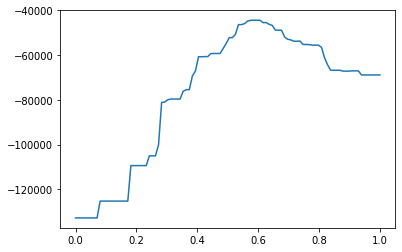

In [66]:
y_proba = model.predict_proba(X_test)[:, 1]
# Función para calcular los costos de FP y FN en un punto de corte
def calculate_th_costs(y_true, y_proba, threshold):
    y_pred = (y_proba >= threshold).astype(int)
    return myscore(y_true, y_pred)

# Generar umbrales entre 0 y 1
thresholds = np.linspace(0, 1, 100)
costs = [calculate_th_costs(y_test, y_proba, t) for t in thresholds]
plt.plot(thresholds, costs)

ATENCION: Disponible en sklearn 1.5 o superior

we use the TunedThresholdClassifierCV to select the cut-off point of the decision function that minimizes the provided business cost.In addition, the original research [1] defines a custom business metric. We call a “business metric” any metric function that aims at quantifying how the predictions (correct or wrong) might impact the business value of deploying a given machine learning model in a specific application context

----

In [67]:
from sklearn.model_selection import TunedThresholdClassifierCV
tuned_model = TunedThresholdClassifierCV(
    estimator=model,
    scoring=custom_scorer,#scoring["cost_gain"],
    store_cv_results=True,  # necessary to inspect all results
)
tuned_model.fit(X_train, y_train)
print(f"{tuned_model.best_threshold_=:0.2f}")

tuned_model.best_threshold_=0.60


In [ ]:
y_pred = model.predict_proba(X_test)[:,1]>0.84
print(myscore(y_test, y_pred))